In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

In [2]:
def rounded_RMSE(y_true, y_pred):
    rounded_preds = np.round(np.array(y_pred))
    return np.sqrt(np.mean((np.array(y_true) - rounded_preds) ** 2))

rounded_rmse_scorer = make_scorer(rounded_RMSE, greater_is_better=False)

# Model 1 : Interpretable Decision Tree

In [13]:
model1_train = pd.read_csv("data/model1_training_features.csv")
training_labels = pd.read_csv('data/train.csv', usecols=['price'])["price"]

model1_test = pd.read_csv("data/model1_testing_features.csv")
testing_ids = pd.read_csv('data/test.csv', usecols=['id'])["id"]

## Hyperparameter Tuning

In [34]:
param_distributions = {
    'max_depth': range(1, 12),
    'min_samples_split': range(20, 300),
    'min_samples_leaf': range(5, 100)
}

hyperparameter_tuning = RandomizedSearchCV(DecisionTreeRegressor(random_state=3, criterion="squared_error"), 
                                           #scoring = 'neg_root_mean_squared_error',
                                           scoring = rounded_rmse_scorer,
                                           param_distributions = param_distributions, 
                                           n_iter = 200,
                                           cv = 5,
                                           random_state=3)

search1 = hyperparameter_tuning.fit(model1_train, training_labels)
search1.best_params_

C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'min_samples_split': 42, 'min_samples_leaf': 8, 'max_depth': 11}

In [35]:
search1.best_score_

-0.9498210966511655

## Refitting w/ Best Parameters and Predicting Test Set

In [36]:
model1 = DecisionTreeRegressor(random_state=3, 
                               criterion = "squared_error",
                               max_depth = search1.best_params_["max_depth"],
                               min_samples_split = search1.best_params_["min_samples_split"],
                               min_samples_leaf = search1.best_params_["min_samples_leaf"])

model1.fit(model1_train, training_labels)
model1_test_preds = np.round(model1.predict(model1_test))

In [33]:
pd.DataFrame(
    {
        "id" : testing_ids,
        "price" : model1_test_preds
    }).to_csv("data/model1_predictions.csv", index=False)

## Feature Importance

In [37]:
model1_importance = pd.DataFrame({"Feature" : model1_train.columns, 
                                  "Gini Importance" : model1.feature_importances_, 
                                  "Permutation Importance" : permutation_importance(model1, model1_train, training_labels, scoring=rounded_rmse_scorer)["importances_mean"]
                                  })

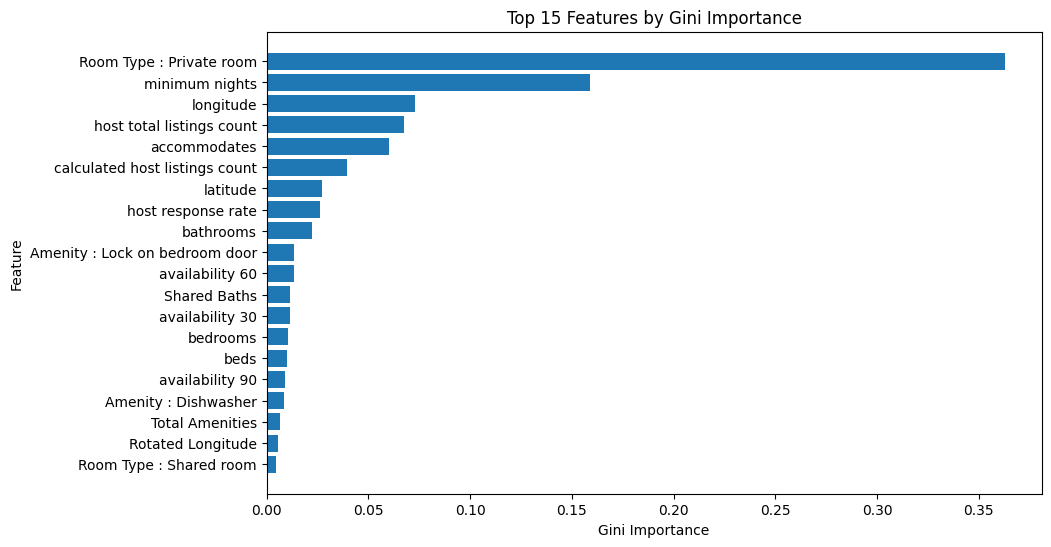

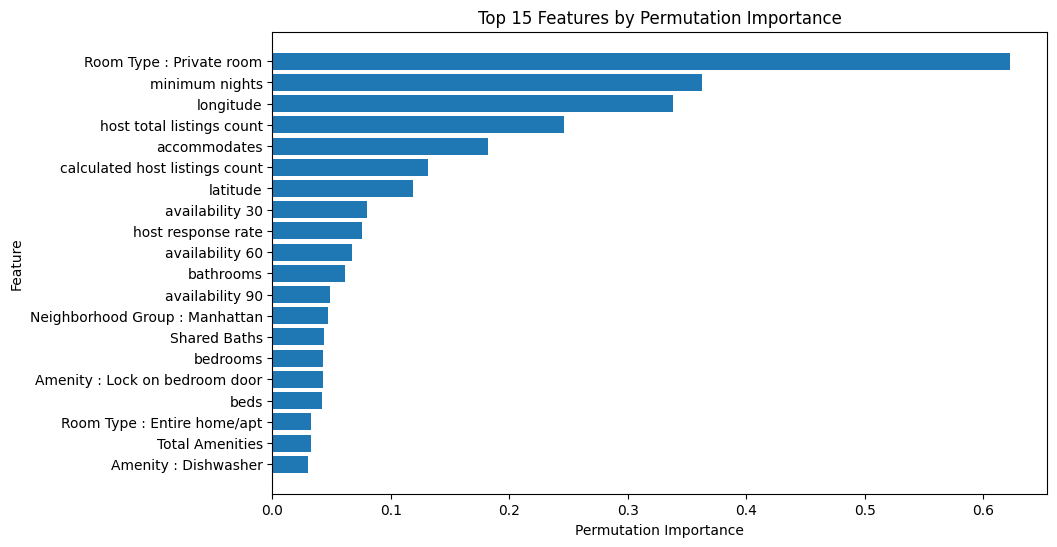

In [38]:
top_gini = model1_importance.nlargest(20, "Gini Importance")
top_permutation = model1_importance.nlargest(20, "Permutation Importance")

plt.figure(figsize=(10, 6))
plt.barh(top_gini["Feature"], top_gini["Gini Importance"], align='center')
plt.gca().invert_yaxis() 
plt.title("Top 20 Features by Gini Importance")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_permutation["Feature"], top_permutation["Permutation Importance"], align='center')
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Permutation Importance")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.show()

# Model 2 : Random Forest and Additional Covariates

In [4]:
model2_train = pd.read_csv("data/model2_training_features.csv")
model2_test = pd.read_csv("data/model2_testing_features.csv")

## Feature Selection

In [125]:
feature_selection_model2 = RandomForestRegressor(random_state=3, 
                                                 criterion = "squared_error",
                                                 n_estimators = 200,
                                                 max_samples = 0.75,
                                                 max_features = 0.4,
                                                 max_depth = 25,
                                                 min_samples_split = 10,
                                                 min_samples_leaf = 3)

feature_selection_model2.fit(model2_train, training_labels)

RandomForestRegressor(max_depth=25, max_features=0.4, max_samples=0.75,
                      min_samples_leaf=3, min_samples_split=10,
                      n_estimators=200, random_state=3)

In [126]:
feature_selection_importance2 = pd.DataFrame({"Feature" : model2_train.columns, 
                                              "Gini Importance" : feature_selection_model2.feature_importances_#, 
                                              #"Permutation Importance" : permutation_importance(feature_selection_model2, model2_train, training_labels, 
                                                                                                #scoring=rounded_rmse_scorer, random_state=3, n_repeats=5, n_jobs=-1
                                                                                                #)["importances_mean"]
                                                                                                })

In [127]:
top_gini = feature_selection_importance2.nlargest(200, "Gini Importance")

model2_train_selected_features = model2_train[[col for col in model2_train.columns if col in top_gini["Feature"].tolist()]]
model2_test_selected_features = model2_test[[col for col in model2_train.columns if col in top_gini["Feature"].tolist()]]

## Hyperparameter Tuning

In [128]:
param_distributions = {
    'max_samples' : uniform(0.5, 0.49), 
    'max_features' : uniform(0.25, 0.5), 
    'max_depth': range(15, 35),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 5)
}

hyperparameter_tuning = RandomizedSearchCV(RandomForestRegressor(random_state=3, criterion="squared_error", n_estimators=200),
                                           scoring = rounded_rmse_scorer,
                                           param_distributions = param_distributions, 
                                           n_iter = 25,
                                           cv = 5,
                                           n_jobs=-1,
                                           random_state=3)


search2 = hyperparameter_tuning.fit(model2_train_selected_features, training_labels)
search2.best_params_

{'max_depth': 34,
 'max_features': 0.7069876335029689,
 'max_samples': 0.8104961262559116,
 'min_samples_leaf': 1,
 'min_samples_split': 7}

In [129]:
search2.best_score_

-0.7847849620914421

## Refitting w/ Best Parameters and Predicting Test Set

In [130]:
model2 = RandomForestRegressor(random_state=3, 
                               criterion = "squared_error",
                               n_estimators =  200,
                               max_samples = search2.best_params_["max_samples"],
                               max_features = search2.best_params_["max_features"],
                               max_depth = search2.best_params_["max_depth"],
                               min_samples_split = search2.best_params_["min_samples_split"],
                               min_samples_leaf = search2.best_params_["min_samples_leaf"])

model2.fit(model2_train_selected_features, training_labels)
model2_test_preds = np.round(model2.predict(model2_test_selected_features))

In [131]:
pd.DataFrame(
    {
        "id" : testing_ids,
        "price" : model2_test_preds
    }).to_csv("data/model2_predictions_post_feature_selection.csv", index=False)

## Feature Importance

In [132]:
model2_importance = pd.DataFrame({"Feature" : model2_train_selected_features.columns, 
                                  "Gini Importance" : model2.feature_importances_, 
                                  "Permutation Importance" : permutation_importance(model2, model2_train_selected_features, training_labels, scoring=rounded_rmse_scorer, n_jobs=-1)["importances_mean"]
                                  })

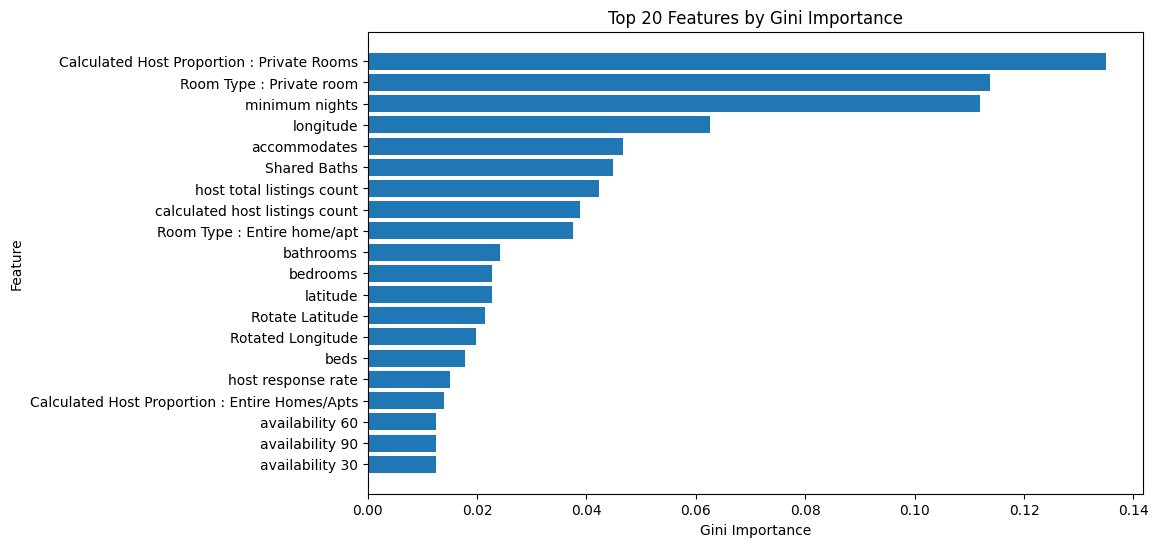

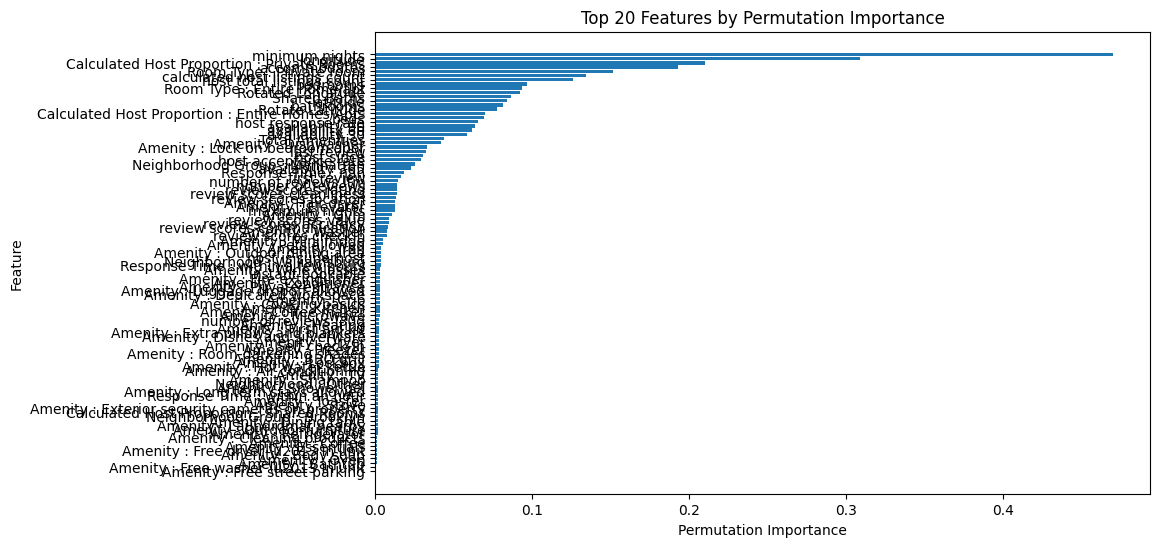

In [111]:
top_gini = model2_importance.nlargest(20, "Gini Importance")
top_permutation = model2_importance.nlargest(100, "Permutation Importance")

plt.figure(figsize=(10, 6))
plt.barh(top_gini["Feature"], top_gini["Gini Importance"], align='center')
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Gini Importance")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_permutation["Feature"], top_permutation["Permutation Importance"], align='center')
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Permutation Importance")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.show()

# Model 3 

In [52]:
model3_train = pd.read_csv("data/model3_training_features.csv")
model3_test = pd.read_csv("data/model3_testing_features.csv")

In [57]:
param_distributions = {
    'n_estimators' : range(500, 700),
    'learning_rate' : uniform(0.05, 0.02),
    'max_depth' : range(6, 10),
    'subsample' : uniform(0.7, 0.29),
    'colsample_bytree' : uniform(0.7,0.29),
    'reg_lambda' : uniform(0.05, 0.5),
    'reg_alpha' : uniform(0.05, 0.5),
}

hyperparameter_tuning = RandomizedSearchCV(xgb.XGBRegressor(random_state=3, objective="reg:squarederror"),
                                           scoring = rounded_rmse_scorer,
                                           param_distributions = param_distributions, 
                                           n_iter = 30,
                                           cv = 8,
                                           #verbose=3,
                                           random_state=3)


search3 = hyperparameter_tuning.fit(model3_train, training_labels)
search3.best_params_

{'colsample_bytree': 0.7117829137302967,
 'learning_rate': 0.05495776594452072,
 'max_depth': 8,
 'n_estimators': 648,
 'reg_alpha': 0.06493810543928348,
 'reg_lambda': 0.27841661219735553,
 'subsample': 0.8882517738082806}

In [58]:
search3.best_score_

-0.7387936916030692

In [59]:
model3 = xgb.XGBRegressor(random_state=3, objective="reg:squarederror",
                          n_estimators =  search3.best_params_["n_estimators"],
                          learning_rate = search3.best_params_["learning_rate"],
                          max_depth = search3.best_params_["max_depth"],
                          subsample = search3.best_params_["subsample"],
                          colsample_bytree = search3.best_params_["colsample_bytree"],
                         reg_alpha  = search3.best_params_["reg_alpha"],
                         reg_lambda = search3.best_params_["reg_lambda"])
                               

model3.fit(model3_train, training_labels)
model3_test_preds = np.round(model3.predict(model3_test))

In [60]:
pd.DataFrame(
    {
        "id" : testing_ids,
        "price" : model3_test_preds
    }).to_csv("data/model3_predictions.csv", index=False)

## Feature Importance

# Model 4 : Neural Net

In [48]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
from keras_tuner import RandomSearch, Objective

In [10]:
from sklearn.decomposition import PCA
# Exclude 'latitude', 'longitude', 'Rotated Latitude', and their corresponding columns
excluded_columns = ['latitude', 'longitude', 'Rotate Latitude', 'Rotated Longitude']
X_non_pca = model3_train[excluded_columns]  # Keep these columns separate
X_for_pca = model3_train.drop(columns=excluded_columns)  # Rest of the data for PCA

# Fit PCA
pca = PCA()  # Start with all components to analyze variance
X_pca = pca.fit_transform(X_for_pca)

# Calculate cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Print explained variance ratio
#for i, ratio in enumerate(explained_variance_ratio, 1):
#    print(f"Number of components: {i}, Cumulative explained variance: {ratio:.4f}")

# Decide how many dimensions to keep (e.g., retaining 95% variance)
n_components_to_keep = sum(explained_variance_ratio <= 0.95) + 1  # Retain at least 95% of variance
print(f"Keeping {n_components_to_keep} components to retain 95% of the variance.")

# Transform data with selected number of components
pca = PCA(n_components=n_components_to_keep)
X_pca_reduced = pca.fit_transform(X_for_pca)

# Combine the PCA-reduced data and the excluded columns
X_final = np.hstack([X_pca_reduced, X_non_pca.to_numpy()])

# Print final shape
print(f"Final dataset shape: {X_final.shape}")

Keeping 343 components to retain 95% of the variance.
Final dataset shape: (15696, 347)


In [50]:
def rounded_rmse_metric(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)  # Round predictions
    # Ensure both y_true and y_pred_rounded are float32
    y_pred_rounded = tf.cast(y_pred_rounded, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    # Compute RMSE
    return tf.sqrt(tf.mean(tf.square(y_true - y_pred_rounded)))


def build_model(hp):
    model = Sequential()

    model.add(layers.Input(shape=(X_final.shape[1],)))
    
    # First Dense Layer
    model.add(layers.Dense(
        units=hp.Int('units_layer1', min_value=120, max_value=200, step=20),  # Tune neurons in layer 1
        activation='relu',
        input_shape=(X_final.shape[1],),
        kernel_regularizer=regularizers.l2(hp.Float('l2_lambda_layer1', min_value=0.001, max_value=0.01, sampling='log'))))
    
    # Dropout after the first layer
    model.add(layers.Dropout(hp.Float('dropout_rate_layer1', min_value=0.4, max_value=0.7, sampling='linear')))  # Tune dropout rate
    
    # Second Dense Layer
    model.add(layers.Dense(
        units=hp.Int('units_layer2', min_value=40, max_value=100, step=10),  # Tune neurons in layer 2
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_lambda_layer2', min_value=0.0002, max_value=0.005, sampling='log'))
    ))
    
    # Dropout after the second layer
    model.add(layers.Dropout(hp.Float('dropout_rate_layer2', min_value=0.3, max_value=0.6, sampling='linear')))  # Tune dropout rate

    # Output Layer
    model.add(layers.Dense(1))  # Regression output (single value)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=0.00005, max_value=0.00015, sampling='linear') 
        ),
        loss='mse',  # Mean Squared Error loss for regression
        metrics=[rounded_rmse_metric]
    )
    return model

In [51]:
y_train = training_labels.to_numpy()

# Initialize Keras Tuner RandomSearch
tuner = RandomSearch(
    build_model,
    objective=Objective("val_rounded_rmse_metric", direction="min"),
    max_trials=25,        # Number of random search trials
    executions_per_trial=1,  # Number of executions per trial
    directory='data',     # Directory to store tuning logs
    project_name='pca_tuning_pt8'
)

tuner.oracle.hyperparameters.Int('batch_size', min_value=16, max_value=64, step=16)

# Perform hyperparameter search
tuner.search(
    X_final, y_train,
    epochs=60,  # Number of epochs for each trial
    validation_split=0.1,
    batch_size=tuner.oracle.hyperparameters.get('batch_size')  # Dynamically use tuned batch size
)


# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 00m 01s]

Best val_rounded_rmse_metric So Far: 1.9337482452392578
Total elapsed time: 00h 02m 19s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
160               |140               |units_layer1
0.0042248         |0.0015613         |l2_lambda_layer1
0.40022           |0.54318           |dropout_rate_layer1
70                |50                |units_layer2
0.0045522         |0.00093879        |l2_lambda_layer2
0.58675           |0.47342           |dropout_rate_layer2
6.6216e-05        |0.0001436         |learning_rate
64                |48                |batch_size

Epoch 1/60


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/ipykernel_556198/3974752069.py", line 7, in rounded_rmse_metric
    return tf.sqrt(tf.mean(tf.square(y_true - y_pred_rounded)))
AttributeError: module 'tensorflow' has no attribute 'mean'
